### Постановка задачи
#### Описание
   
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. 
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 


Задача — провести анализ и подготовить план действий по удержанию клиентов.
А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    
    1) выделить целевые группы клиентов;
    
    2) предложить меры по снижению оттока;
    
    3) определить другие особенности взаимодействия с клиентами.

#### Оглавление

- <a href = '#ch1'>Загрузка и исследовательский анализ данных</a>
 - <a href = '#ch1_v'>Вывод</a>
- <a href = '#ch2'>Модель для прогнозирования оттока клиентов на примере логистической регрессии и модели случайного леса</a>
 - <a href = '#ch2_v'>Вывод</a>
- <a href = '#ch3'>Кластеризация клиентов</a>
 - <a href = '#ch3_v'>Вывод</a>
- <a href = '#ch4'>Общий вывод и рекомендации</a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

#### <a id='ch1'>Загрузка и исследовательский анализ данных</a>

In [3]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')

In [4]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [5]:
gym_churn.duplicated().sum()

0

In [6]:
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [7]:
#
gym_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Данная таблица дает нам понять характеристики среднего клиента. Ему, в среднем, 29 лет (+-3 года), в среднем, больше 3‑х месяцев ходит в фитнес-клуб, и примерно 2 раза в неделю его посещает, на доп.товарах и услугах тратит от 50 до 250.

In [8]:
#Сравним средние значения признаков для тех, кто ушел и остался.  
gym_churn.groupby('Churn')\
[['Age', 'Avg_additional_charges_total', 'Avg_class_frequency_total',\
  'Avg_class_frequency_current_month', 'Lifetime', 'Contract_period']].mean()

,Age,Avg_additional_charges_total,Avg_class_frequency_total,Avg_class_frequency_current_month,Lifetime,Contract_period
Churn,,,,,,
0,29.976523,158.445715,2.024876,2.027882,4.711807,5.747193
1,26.989632,115.082899,1.474995,1.044546,0.990575,1.728558


Разница между теми кто остался и ушел в средних показателях хорошо заметна. В группе оттока клиенты в среднем имеющие меньший возраст (27 лет против 29), меньше дополнительно тратят и реже посещают фитнес-центр.

<Figure size 432x288 with 0 Axes>

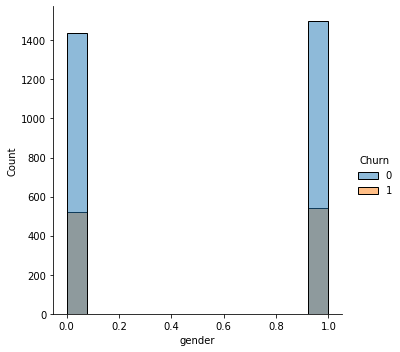

<Figure size 432x288 with 0 Axes>

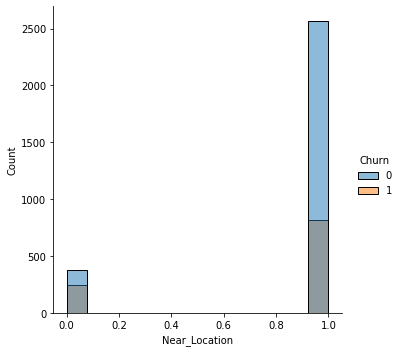

<Figure size 432x288 with 0 Axes>

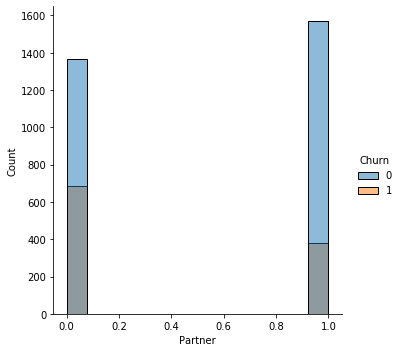

<Figure size 432x288 with 0 Axes>

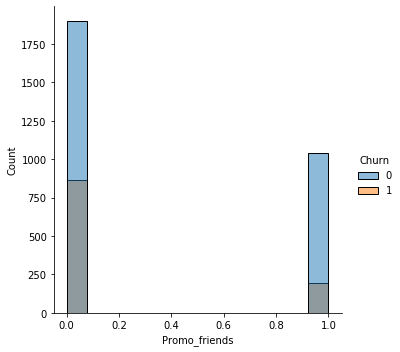

<Figure size 432x288 with 0 Axes>

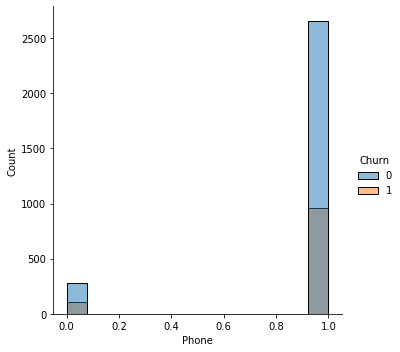

<Figure size 432x288 with 0 Axes>

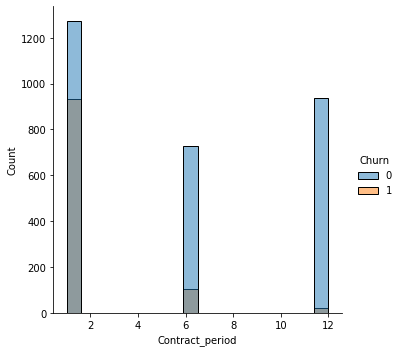

<Figure size 432x288 with 0 Axes>

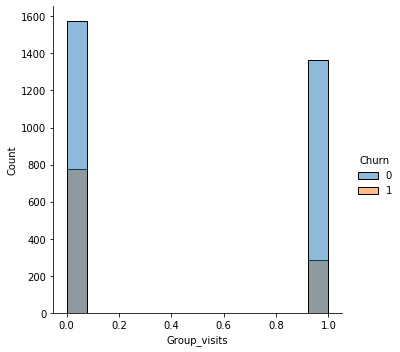

<Figure size 432x288 with 0 Axes>

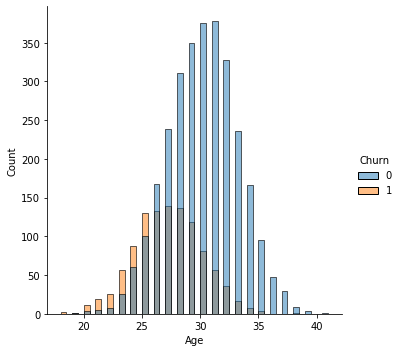

<Figure size 432x288 with 0 Axes>

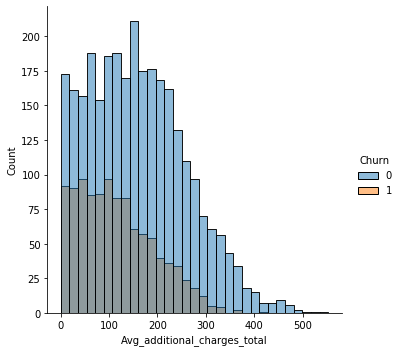

<Figure size 432x288 with 0 Axes>

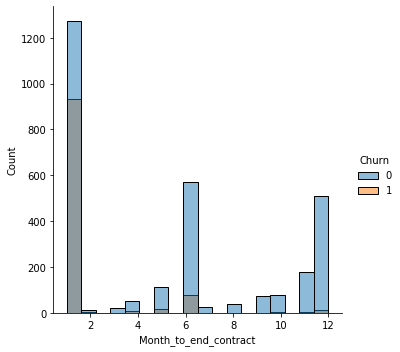

<Figure size 432x288 with 0 Axes>

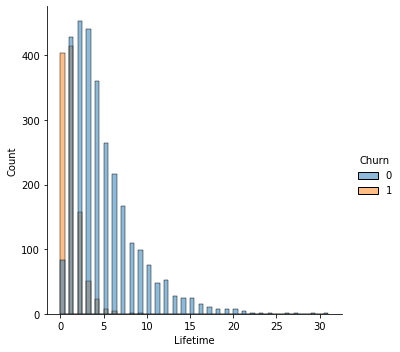

<Figure size 432x288 with 0 Axes>

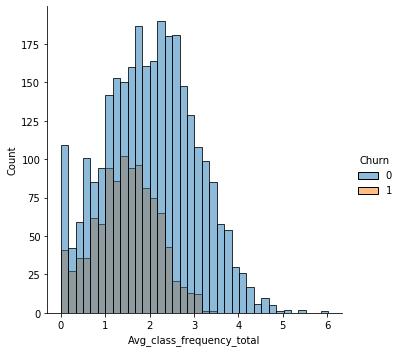

<Figure size 432x288 with 0 Axes>

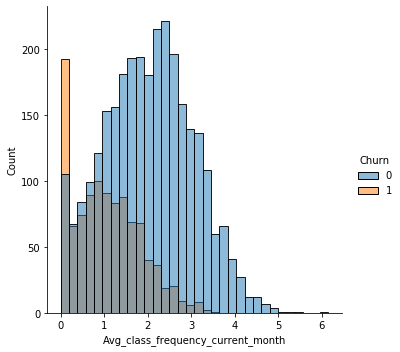

<Figure size 432x288 with 0 Axes>

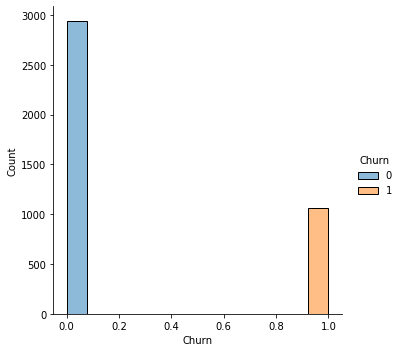

In [9]:
#Графики признаков в разрезе групп. 
for i in gym_churn.columns:
    plt.figure()
    sns.displot(data = gym_churn, x=i, hue="Churn")
    plt.show()

        На графиках выше можно пронаблюдать распределения признаков наших 2‑х групп. Наглядно видно, как клиенты, которые продолжают пользоваться услугами Фитнес-центра, так скажем имеют больший вес в каждом из признаков. К примеру, имеют больший средний возраст, в среднем чаще посещают фитнес-центр, дополнительно больше тратят и так далее.

In [10]:
corr_gym_churn= gym_churn.corr()

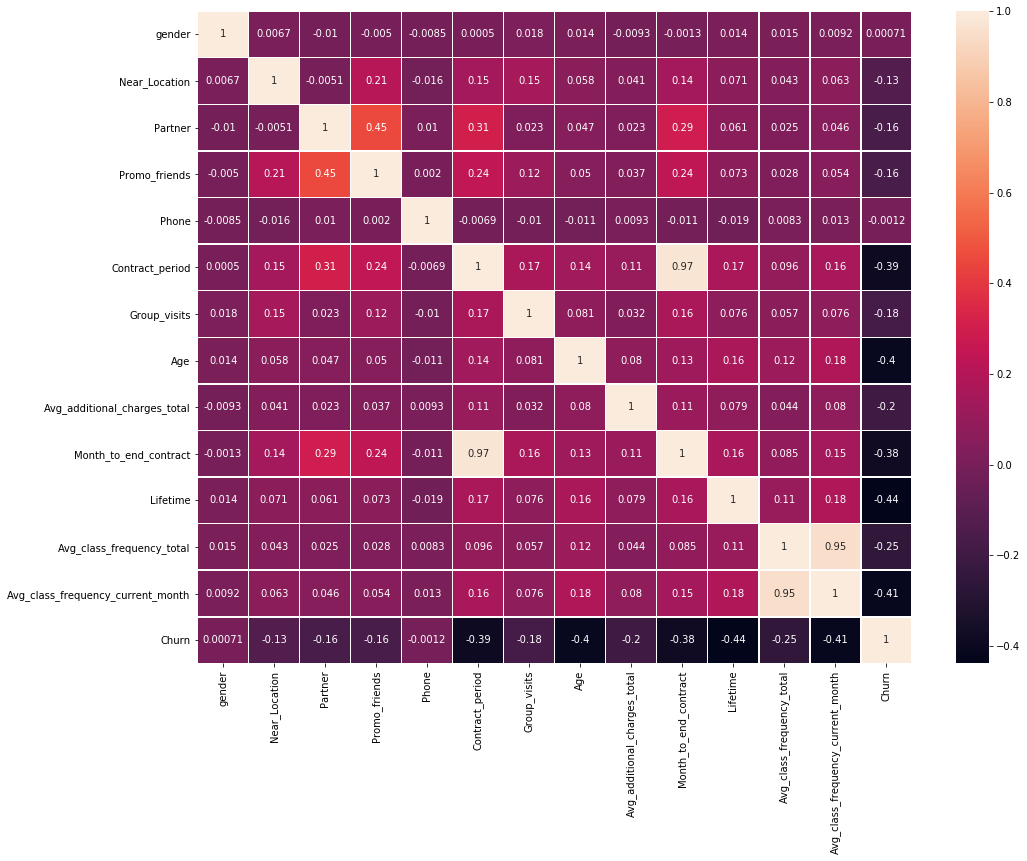

In [11]:
plt.figure(figsize=(16,12))
sns.heatmap(corr_gym_churn, annot=True, linewidths=.5)
plt.show()

In [12]:
gym_churn = gym_churn.drop(['Month_to_end_contract', 'Avg_class_frequency_current_month'], axis=1)

#### <a id='ch1_v'>Вывод:</a>
        Имеем таблицу gym_churn включающую в себя 13 столбцов с признаками и целевой столбец Churn. Всего 4000 записей, все записи имеют количественные переменные. В таблице нет пропусков и дубликатов. Средний возраст наших клиентов 29 лет, со стандартным отклонением в 3 года. Средний клиент, учитывая стандартное отклонение, посещает спортзал от 1 до 3 раз в неделю. Так же наш средний клиент дополнительно потратит на сопутствующие товары и услуги от 50 до 250 рублей. Можем отметить, что средний клиент, чаще берет абонемент на месяц, а ходит в фитнес-клуб 3.

        Отметим, что хорошо заметна разница в средних показателях клиентов тех, что остаются и уходят. Средний возраст клиентов, которые остаются на уровне 30 лет, а вот клиенты по моложе, в среднем 27 имеют склонность уходить. Так же клиенты которые в среднем меньше дополнительно тратили 115 против 158, реже посещали фитнес-клуб 1.5 раза в неделю против 2, в последний месяц ходили еще реже всего 1 раз в неделю, и продолжительность посещений, в среднем, не превысила месяца. Что касается клиентов, которые остаются. То мы уже отметили, что они больше тратят в среднем на доп. услуги, чаще посещают зал и абонемент они выбирают чаще  на 1 месяц.
        
        В таблице имеются сильно коррелирующие признаки 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год) и 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах) их значение корреляции равно 97, так же сильно коррелируют 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента и 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц. Было принято решение избавиться от признака 'Month_to_end_contract' и 'Avg_class_frequency_current_month'.

____

#### <a id='ch2'>Модель для прогнозирования оттока клиентов на примере логистической регрессии и модели случайного леса</a>

In [13]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [14]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop('Churn', axis=1)
y = gym_churn['Churn']

In [15]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
# Приведем выборку к единому масштабу
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [17]:
warnings.filterwarnings('ignore')
# Алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)

# обучим модель
lr_model.fit(X_train_st, y_train)

# Сделаем прогноз
lr_predictions = lr_model.predict(X_test_st)

In [18]:
print_all_metrics(y_test, lr_predictions,  title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.81


In [19]:
warnings.filterwarnings('ignore')
# Алгоритм для модели случайного леса
rfc_model = RandomForestClassifier(random_state=0)

# обучим модель
rfc_model.fit(X_train_st, y_train)

# Сделаем прогноз
rfc_predictions = rfc_model.predict(X_test_st)

In [20]:
print_all_metrics(y_test, rfc_predictions,  title='Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.88
	Precision: 0.77
	Recall: 0.72


#### <a id='ch2_v'>Вывод</a>
        Доля правильных ответов (Метрика Accuracy) в обеих метриках одинакова, но нужно оговориться, что мы имеем не равное количество объектов каждого класса, тех кто остался (0) - 2939 и группа оттока (1) - 1061, что влияет на определение точности.  Метрики Точность(Precision) и Полнота(Recall) лучше определяют в логистической регрессии. Можем сказать, что модель логистической регрессии лучше себя показала. 

####  <a id='ch3'>Кластеризация клиентов</a>

In [21]:
X_sc = scaler.fit_transform(X)

In [22]:
#Строим матрицу расстояний
linked = linkage(X_sc, method = 'ward') 

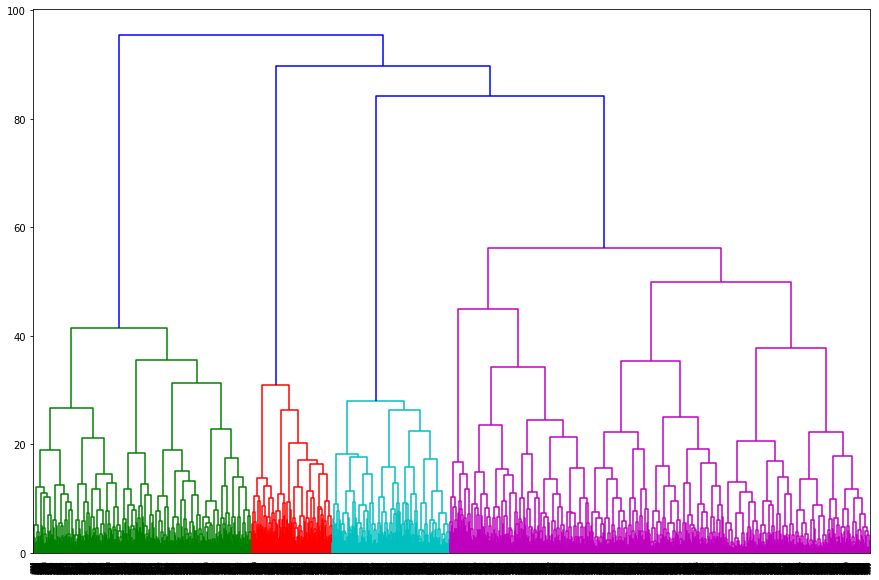

In [23]:
#Строим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

На основании дендрограммы можно выделить 4 кластера.

In [24]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

In [25]:
gym_churn['cluster_km'] = labels

In [26]:
gym_churn.groupby('cluster_km')\
[['Age', 'Avg_additional_charges_total', 'Avg_class_frequency_total', 'Lifetime', 'Contract_period']].mean()

,Age,Avg_additional_charges_total,Avg_class_frequency_total,Lifetime,Contract_period
cluster_km,,,,,
0,28.721925,137.540009,1.770413,3.060606,3.032086
1,29.543810,155.861428,1.978963,4.380952,7.660952
2,28.770318,143.383993,1.800647,3.343640,2.819788
3,29.536165,148.088897,1.941342,3.761194,4.528129
4,29.297927,144.208179,1.854211,3.940415,4.777202


Различия средних значений признаков, по разным кластерам, хорошо заметны. 

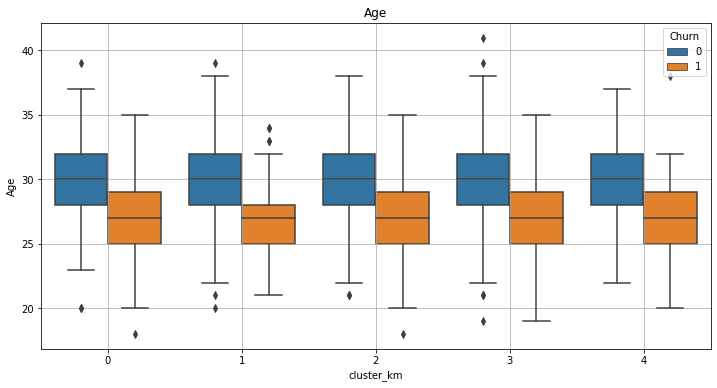

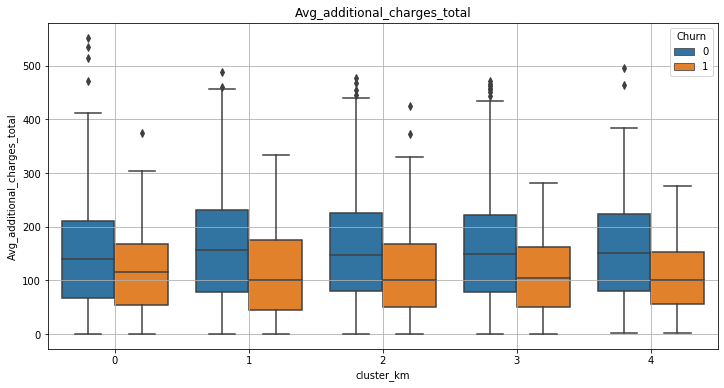

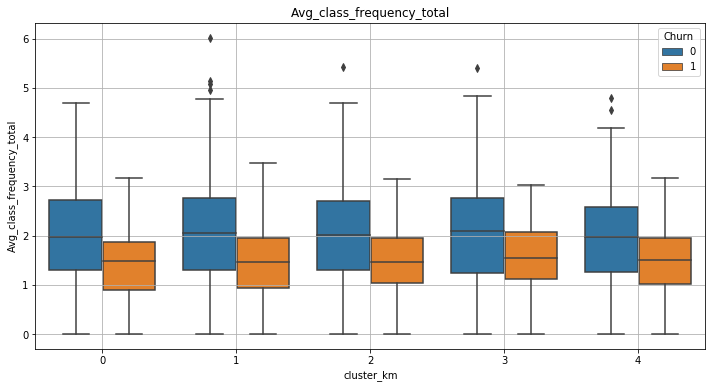

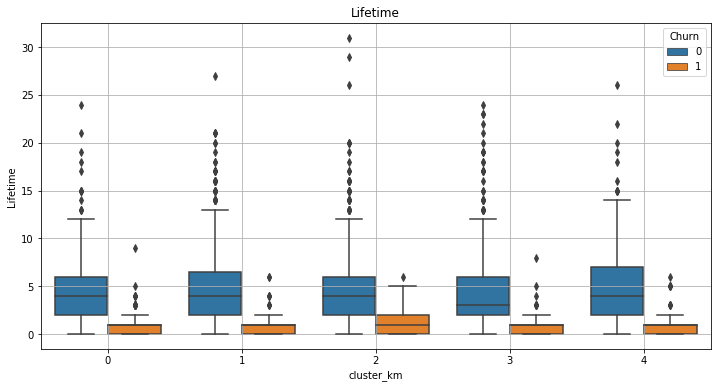

In [27]:
for i in ['Age', 'Avg_additional_charges_total', 'Avg_class_frequency_total', 'Lifetime']:
    plt.figure(figsize=(12,6))
    plt.title(i)
    sns.boxplot(x='cluster_km', y=i, data=gym_churn , hue="Churn")
    plt.grid(True)
    plt.show()

<Figure size 432x288 with 0 Axes>

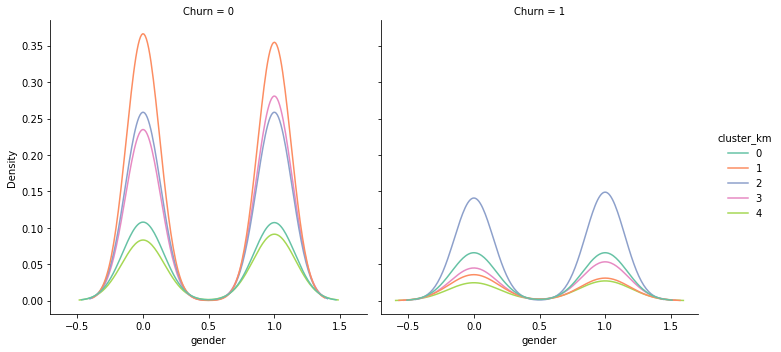

<Figure size 432x288 with 0 Axes>

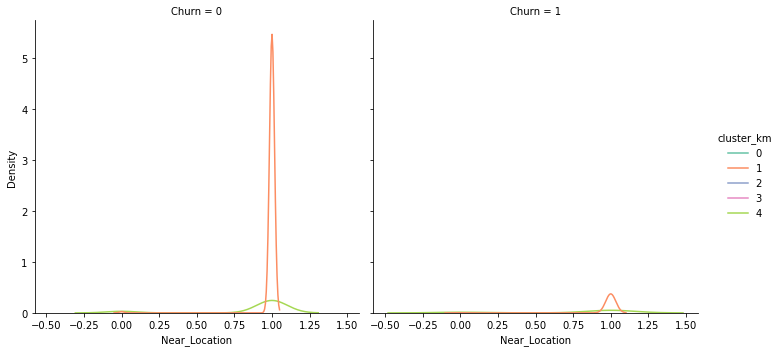

<Figure size 432x288 with 0 Axes>

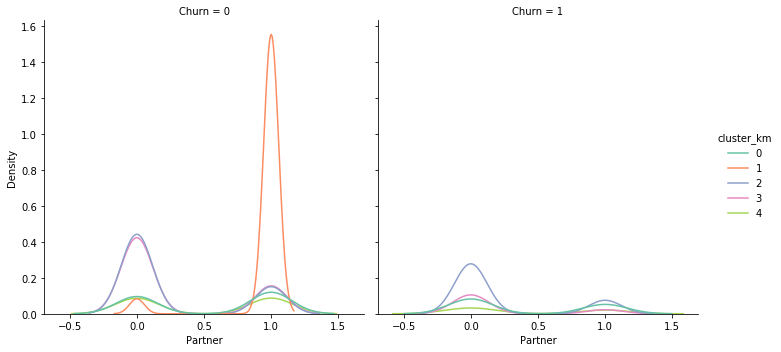

<Figure size 432x288 with 0 Axes>

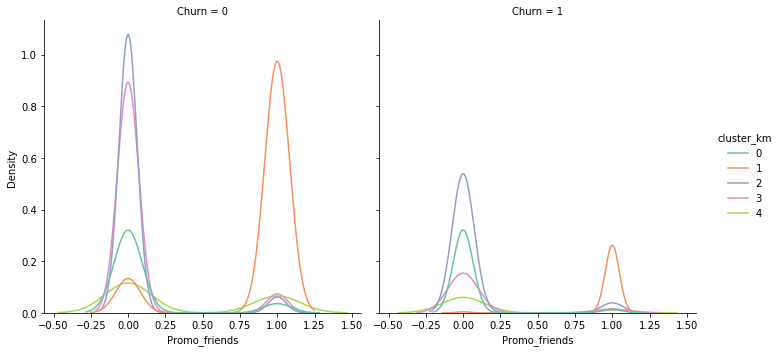

<Figure size 432x288 with 0 Axes>

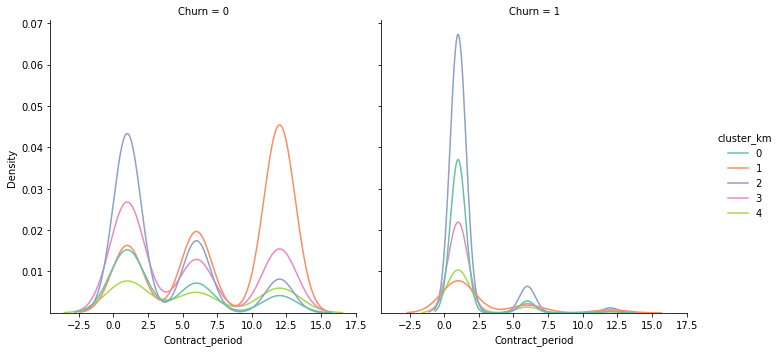

<Figure size 432x288 with 0 Axes>

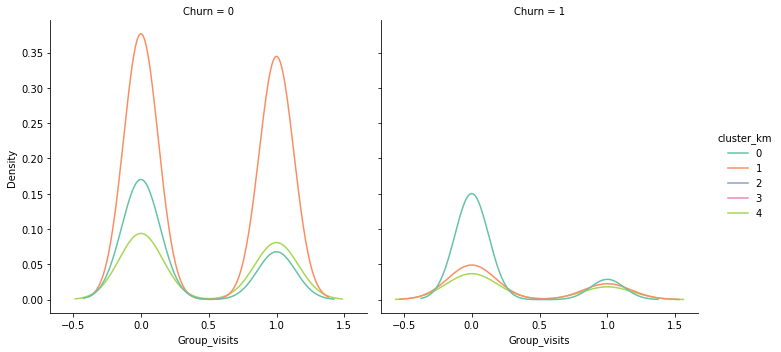

In [28]:
warnings.filterwarnings('ignore')
for i in gym_churn.drop(['Age', 'Avg_additional_charges_total', 'Avg_class_frequency_total', 'Lifetime','Churn', 'cluster_km', 'Phone'], axis=1).columns:
    plt.figure()
    sns.displot(data = gym_churn, x=i, hue="cluster_km", palette="Set2", kind="kde", col='Churn')
    plt.show()

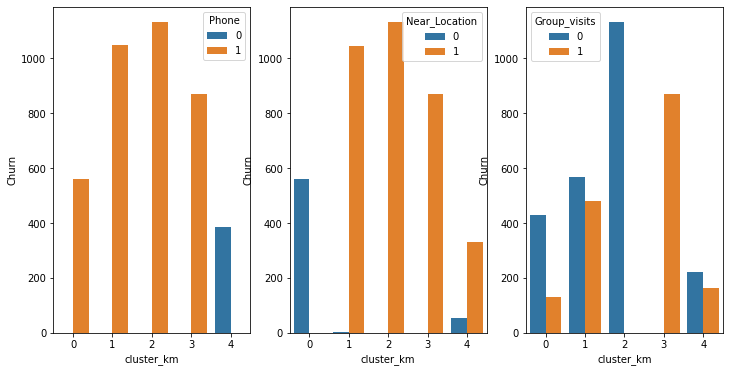

In [29]:
plt.figure(figsize=(12,6))

plt.subplot(131)
sns.barplot(x="cluster_km", y='Churn',\
            data=gym_churn.groupby(['Phone','cluster_km'])['Churn'].count().reset_index(), hue='Phone')

plt.subplot(132)

sns.barplot(x="cluster_km", y='Churn',\
            data=gym_churn.groupby(['Near_Location','cluster_km'])['Churn'].count().reset_index(), hue='Near_Location')

plt.subplot(133)

sns.barplot(x="cluster_km", y='Churn',\
            data=gym_churn.groupby(['Group_visits','cluster_km'])['Churn'].count().reset_index(), hue='Group_visits')
plt.show()



In [30]:
group_visits = gym_churn.groupby(['Group_visits','cluster_km','Churn']).agg({'gender':'count'}).reset_index()
group_visits.columns = ['group_visits', 'cluster_km', 'churn', 'count']

phone = gym_churn.groupby(['Phone','cluster_km','Churn']).agg({'gender':'count'}).reset_index()
phone.columns = ['Phone', 'cluster_km', 'churn', 'count']

Near_Location = gym_churn.groupby(['Near_Location','cluster_km','Churn']).agg({'gender':'count'}).reset_index()
Near_Location.columns = ['Near_Location', 'cluster_km', 'churn', 'count']

gender = gym_churn.groupby(['gender','cluster_km','Churn']).agg({'Near_Location':'count'}).reset_index()
gender.columns = ['gender', 'cluster_km', 'churn', 'count']

In [31]:
#Функция вернет график, который покажет распределение клиентов, в зависимости от характеристики, группы и факта оттока
def graff(df):
    plt.figure(figsize=(12,6))
    i = df.columns[0]

    g = sns.catplot(x=i, y='count',\
            data=df,\
            hue='churn', kind='bar', col='cluster_km')
    g.set_titles(i)
        

<Figure size 864x432 with 0 Axes>

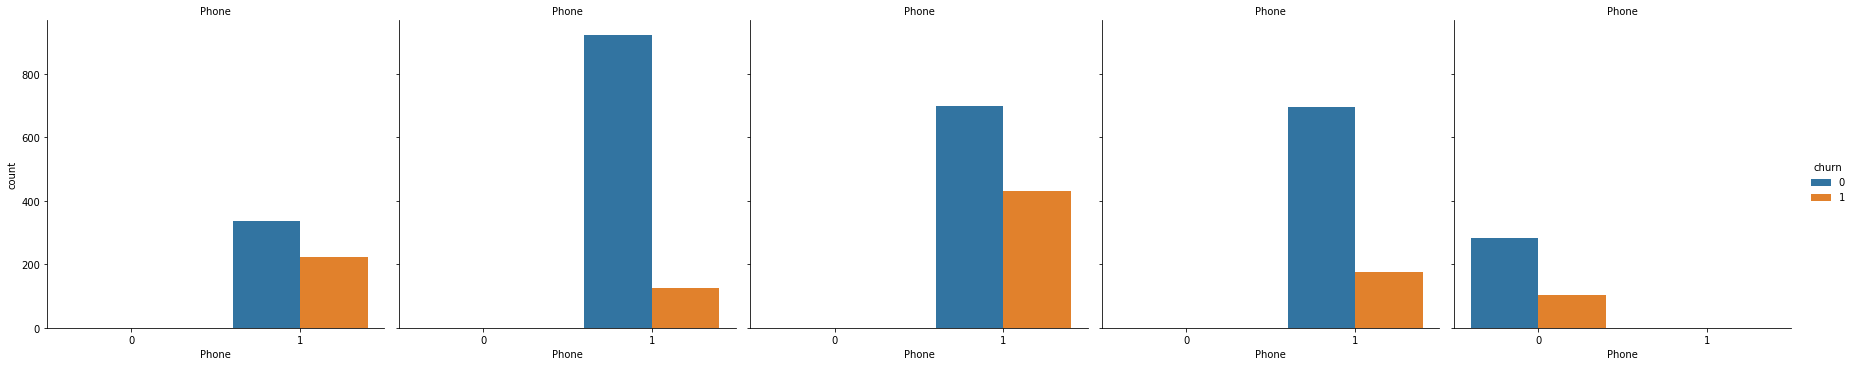

In [32]:
#Контактные данные
graff(phone)

<Figure size 864x432 with 0 Axes>

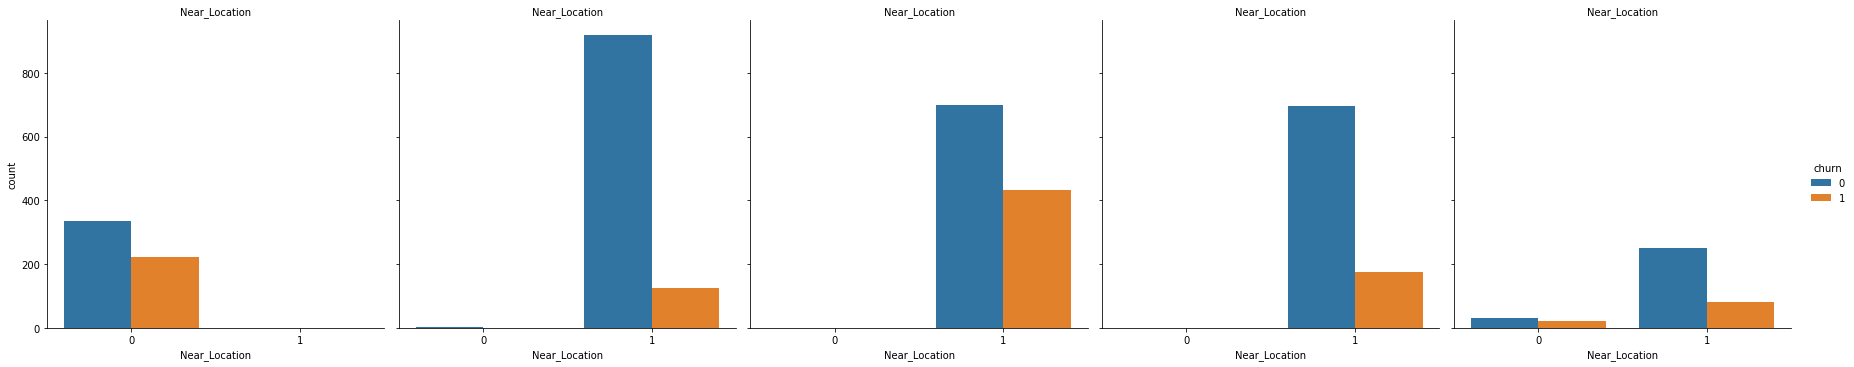

In [33]:
#Проживание или работа в районе, где находится фитнес-центр
graff(Near_Location)

<Figure size 864x432 with 0 Axes>

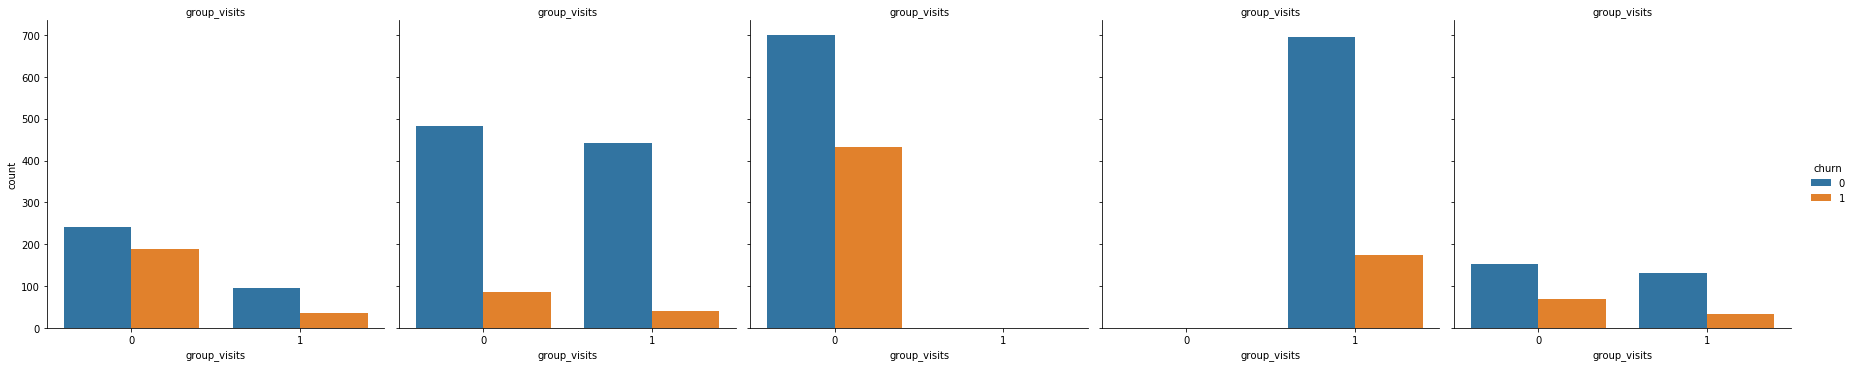

In [34]:
#Посещение групповых занятий
graff(group_visits)

In [35]:
#Доля оттока по каждому кластеру
round(gym_churn.query('Churn==1').groupby('cluster_km')['Churn'].count() / gym_churn.groupby('cluster_km')['Churn'].count(),2)

cluster_km
0    0.40
1    0.12
2    0.38
3    0.20
4    0.27
Name: Churn, dtype: float64

#### <a id='ch3_v'>Вывод:</a>
Кластер под номером 1 имеет наименьший процент оттока. Клиенты этой группы имеют следующие характеристики:
- Средний возраст 29,5 лет;
- Клиенты этой группы в среднем больше тратятся на доп.услуги;
- посещают фитнес-центр примерно 2 раза в неделю;
- они участвуют в партнерской программе или же их пригласили друзья;
- такие клиенты оставляют свои контактные данные;
- берут более длительные абонементы.

Так же можем отметить третий кластер. Он имеет свои особенности, к примеру, состоит из клиентов, которые любят групповые занятия
Если клиент попадает в один из этих кластеров, то вероятность того, что он останется выше.

Также оказалось, что в 4 группу были определены клиенты, которые не оставляли контактного телефона, а те клиенты, которые живут или работают не в районе Фитнес-центра, большинством расположились в нулевой группе. Быть может это и влияет на процент оттока в этих группах. Что касается групповых занятий, то тут сложно сказать наверняка, но мы видим, что во 1 и 3 группах, таких клиентов больше, а 2 группа, с оттоком клиентов в 38%, имеет преобладающее количество не посещающих групповые занятия.

#### Рассмотрим несколько ярких портретов клиентов и распределим их по риску оттока:
1. Высокий риск вероятности оттока. Возраст клиента менее 28 лет, редко посещает Фитнес-центр, в среднем, 1,5 раза в неделю. Не заинтересован в групповых посещениях, предпочитаемый абонемент на 1 месяц. Средняя продолжительность посещения до 3 месяцев. Так же, такой клиент проживает или работает, не в районе, где находится Фитнес-центр, не оставляет своих контактных данных.


2. Средний риск оттока. Возраст клиента в районе 29 лет, посещает Фитнес-центр, в среднем, около 2-х раз в неделю. Скорее он будет похож на среднего клиента в общем. Сложно определить его границу. Ведь такой клиент может и посещать и не посещать групповые занятия, может оставлять и не оставлять контактные данные. Но следя за такими показателям, как доп.затраты частота посещения и средняя продолжительность посещения, можно понять нравится ли этому клиенту этот фитнес-центр.


3. Низкий риск оттока. Сюда попадают клиенты со средним возрастом от 29 лет и выше, они, в среднем, посещают фитнес-центр больше 2‑х раз в неделю, они берут годовые абонементы, такие клиенты чаще пользуются доп. услугами. Многие из них пришли по партнерской программе, либо же их привел друг. Такие клиенты посещают групповые занятия, а продолжительность посещения перевалила за 4 месяца.

#### <a id='ch4'>Общий вывод и рекомендации:</a>
        Используя модели логистической регрессии и случайного леса мы научились прогнозировать вероятность оттока клиентов. Логическая регрессия показала себя лучше в прогнозирование оттока. Было выделено 5 групп клиентов, каждая группа показала разную долю вероятности оттока клиента. Наиболее стабильные, и с меньшей долей вероятности оттока, это 1 и 3 группы.
        Клиенты в разных группах имеют свои средние характеристики и по ним было выделено 3 группы, в зависимости от риска оттока. В каждой группе описан портрет клиента. Сильными и выделяющими характеристиками, влияющими на отток, оказался возраст, количество посещений, так же на отток влияют такие характеристики, как наличие контактов, средние дополнительные траты и посещение групповых занятий и проживание или работа в районе фитнес-центра.
        Положительными характеристиками на удержания клиента являются партнерские программы, посещение групповых занятий, факт того оставил ли клиент свои данные.
        Для удержания клиентов, можно попросить заполнить им свои данные, возможно, они трудятся в партнерской компании. Предложение групповых занятий, возможно даст положительный эффект, а так же, если клиент приведет друга, который получит скидку. Сами по себе скидки действуют положительно. Установив возраст менее 27 лет, для того что бы посмотреть, что удерживает таких клиентов, дополнительно было выявлено, что клиенты покупающие абонементы сроком на год, остаются вместе с компанией. Поэтому так же для удержания клиентов предлагать скидки, на более продолжительные абонементы. 